## Latency vs. number of robots (LIBERO)

This notebook scans the LIBERO benchmark folders under:

- `/srv/rl2-lab/flash8/rbansal66/vvla/openpi/data/libero`

and produces a **latency vs. number of robots** plot comparing:

- **non-realtime**: `batch_1_robots_{N}`
- **realtime**: `batch_1_robots_{N}_realtime`

Notes:
- `ActionChunk.latency` in `examples/libero/schemas.py` is **in seconds**; plots below convert to **milliseconds** (ms).



In [35]:
from __future__ import annotations

import re
import sys
from pathlib import Path
from typing import Dict, Iterator, List, Optional, Tuple

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
import pandas as pd


def find_project_root(start: Path) -> Path:
    start = start.resolve()
    for p in [start, *start.parents]:
        if (p / "examples" / "libero" / "schemas.py").exists():
            return p
    return start


PROJECT_ROOT = find_project_root(Path.cwd())
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from examples.libero.schemas import ActionChunk  # noqa: E402

DATA_ROOT = Path("/srv/rl2-lab/flash8/rbansal66/vvla/openpi/data/libero")
assert DATA_ROOT.exists(), f"Missing data root: {DATA_ROOT}"

# Pick which sweep to plot
SWEEP_ROOT = DATA_ROOT / "batch_sweep_20260102_234118"
assert SWEEP_ROOT.exists(), f"Missing sweep root: {SWEEP_ROOT}"

# New sweep format: batch_{B}_robots_{R}_{realtime|non_realtime}
SWEEP_DIR_RE = re.compile(r"^batch_(?P<batch_size>\d+)_robots_(?P<num_robots>\d+)_(?P<mode>realtime|non_realtime)$")

# Legacy format (kept for convenience): batch_1_robots_{N} and batch_1_robots_{N}_realtime
LEGACY_DIR_RE = re.compile(r"^batch_(?P<batch>\d+)_robots_(?P<num_robots>\d+)(?P<realtime>_realtime)?$")


def iter_experiment_dirs(root: Path) -> Iterator[Tuple[int, int, str, Path]]:
    """Yield (batch_size, num_robots, mode, path)."""
    for p in sorted(root.iterdir()):
        if not p.is_dir():
            continue

        m = SWEEP_DIR_RE.match(p.name)
        if m:
            yield int(m.group("batch_size")), int(m.group("num_robots")), m.group("mode"), p
            continue

        # allow legacy layout if someone points root at DATA_ROOT
        m = LEGACY_DIR_RE.match(p.name)
        if m:
            batch_id = int(m.group("batch"))
            num_robots = int(m.group("num_robots"))
            mode = "realtime" if m.group("realtime") else "non_realtime"
            yield batch_id, num_robots, mode, p


def load_latencies_ms(batch_dir: Path) -> Tuple[np.ndarray, int]:
    """Return (latencies_ms, n_runs) from all `*/*/action_chunks.csv` in a batch dir."""
    action_chunk_csvs = sorted(batch_dir.glob("*/*/action_chunks.csv"))

    lat_s: List[float] = []
    for csv_path in action_chunk_csvs:
        chunks = ActionChunk.from_csv(csv_path)
        lat_s.extend([c.latency for c in chunks])

    lat_ms = np.asarray(lat_s, dtype=np.float64) * 1000.0
    return lat_ms, len(action_chunk_csvs)


def summarize_latencies(lat_ms: np.ndarray) -> dict:
    if lat_ms.size == 0:
        return {
            "n_chunks": 0,
            "mean_ms": np.nan,
            "p50_ms": np.nan,
            "p90_ms": np.nan,
            "p95_ms": np.nan,
            "p99_ms": np.nan,
        }

    return {
        "n_chunks": int(lat_ms.size),
        "mean_ms": float(np.mean(lat_ms)),
        "p50_ms": float(np.percentile(lat_ms, 50)),
        "p90_ms": float(np.percentile(lat_ms, 90)),
        "p95_ms": float(np.percentile(lat_ms, 95)),
        "p99_ms": float(np.percentile(lat_ms, 99)),
    }


def load_success_rate(exp_dir: Path) -> Tuple[float, int]:
    """Return (success_rate, n_episodes) for an experiment directory.

    Prefers `results.csv` (episode-level), falls back to `summary.csv`.
    """

    results_path = exp_dir / "results.csv"
    if results_path.exists():
        df = pd.read_csv(results_path)
        if "success" not in df.columns:
            raise ValueError(f"Missing 'success' column in {results_path}")

        # Handle bool / True/False strings
        success = df["success"]
        if success.dtype == object:
            success = success.astype(str).str.lower().isin(["true", "1", "yes"])
        else:
            success = success.astype(bool)

        n = int(len(success))
        rate = float(success.mean()) if n > 0 else float("nan")
        return rate, n

    summary_path = exp_dir / "summary.csv"
    if summary_path.exists():
        sdf = pd.read_csv(summary_path)
        if "success" not in sdf.columns:
            raise ValueError(f"Missing 'success' column in {summary_path}")
        # This file is task-level aggregated; treat it as already a rate.
        rate = float(sdf["success"].mean())
        return rate, int(len(sdf))

    return float("nan"), 0



In [36]:
rows = []

for batch_size, num_robots, mode, exp_dir in iter_experiment_dirs(SWEEP_ROOT):
    lat_ms, n_runs = load_latencies_ms(exp_dir)
    stats = summarize_latencies(lat_ms)

    rows.append(
        {
            "batch_size": int(batch_size),
            "num_robots": int(num_robots),
            "mode": str(mode),
            "n_runs": int(n_runs),
            **stats,
        }
    )

latency_df = (
    pd.DataFrame(rows)
    .sort_values(["batch_size", "num_robots", "mode"])
    .reset_index(drop=True)
)
latency_df


,batch_size,num_robots,mode,n_runs,n_chunks,mean_ms,p50_ms,p90_ms,p95_ms,p99_ms
0,1,1,non_realtime,10,95,94.070924,95.218420,97.278833,97.434640,97.475133
1,1,1,realtime,10,94,46.336215,47.275543,47.477555,47.563612,51.600428
2,1,2,non_realtime,20,183,93.348216,93.320131,96.907377,97.350836,106.162009
3,1,2,realtime,20,189,46.420063,47.334433,47.514629,47.531033,49.081745
4,1,3,non_realtime,30,280,93.868353,94.165802,97.315025,97.410607,118.973665
...,...,...,...,...,...,...,...,...,...,...
79,64,5,realtime,50,223,4598.657930,4990.426779,5028.963518,6212.408805,6351.959615
80,64,10,non_realtime,100,409,3905.603288,4038.605690,4133.060455,4347.729397,4379.856520
81,64,10,realtime,100,442,4416.538925,4993.276358,5044.245982,5503.455663,6077.581449
82,64,20,non_realtime,200,910,3755.123816,3883.060336,4076.230693,4139.533782,4347.000401


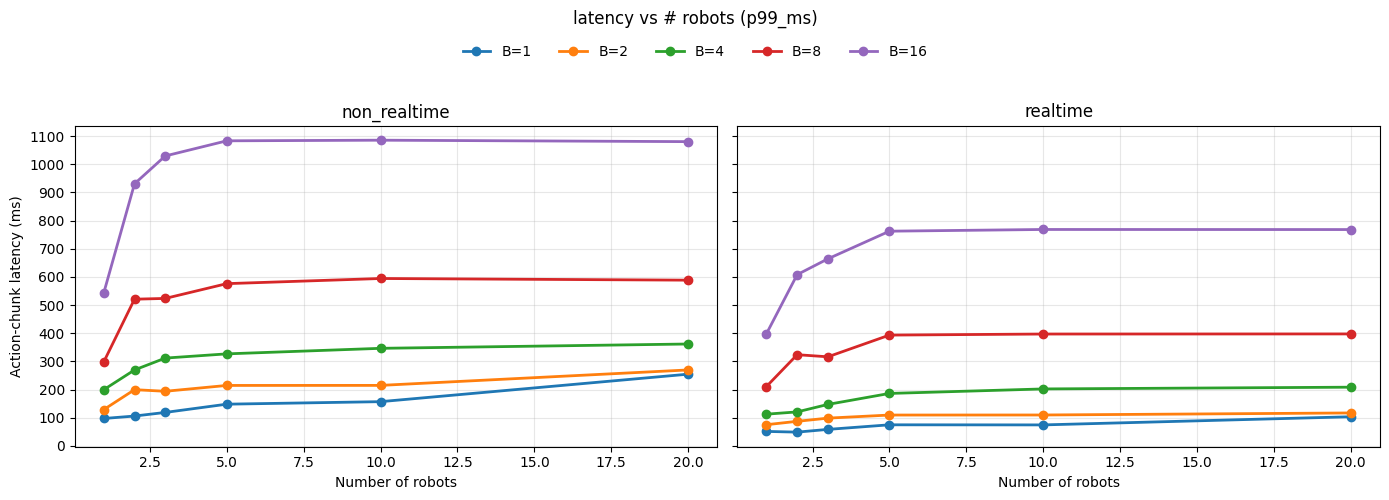

In [54]:
# --- Plot configuration ---
# Control which batch sizes appear in the plots.
# - Set BATCH_SIZES_INCLUDE to a list like [1, 2, 4] to plot only those.
# - Or leave it as None to plot all available batch sizes.
# - Set BATCH_SIZES_EXCLUDE to hide specific batch sizes (e.g. [64]).
BATCH_SIZES_INCLUDE: Optional[List[int]] = None
BATCH_SIZES_EXCLUDE: List[int] = [64, 32]

# If False, we'll plot only one batch size (FIXED_BATCH_SIZE) as realtime vs non_realtime.
PLOT_BATCH_SIZES = True
FIXED_BATCH_SIZE = 1

METRIC = "p99_ms"  # p50_ms / p90_ms / p95_ms / p99_ms / mean_ms


def resolve_batch_sizes(
    df: pd.DataFrame,
    *,
    include: Optional[List[int]] = None,
    exclude: Optional[List[int]] = None,
) -> List[int]:
    available = sorted(df["batch_size"].dropna().unique().astype(int).tolist())
    selected = available if include is None else sorted(set(include))

    if exclude:
        selected = [b for b in selected if b not in set(exclude)]

    # Keep only those that actually exist in the dataframe
    selected = [b for b in selected if b in set(available)]
    return selected


def plot_latency_vs_robots_sweep(
    df: pd.DataFrame,
    *,
    metric: str = "p99_ms",
    batch_sizes: Optional[List[int]] = None,
    num_robots_order: Optional[List[int]] = None,
):
    """Two-panel plot: (non_realtime) vs (realtime), lines for each batch size."""

    if batch_sizes is None:
        batch_sizes = resolve_batch_sizes(df, include=BATCH_SIZES_INCLUDE, exclude=BATCH_SIZES_EXCLUDE)

    if num_robots_order is None:
        num_robots_order = sorted(df["num_robots"].dropna().unique().astype(int).tolist())

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    mode_to_ax = {"non_realtime": axes[0], "realtime": axes[1]}

    colors = {b: f"C{i % 10}" for i, b in enumerate(batch_sizes)}

    for mode, ax in mode_to_ax.items():
        for b in batch_sizes:
            sub = df[(df["mode"] == mode) & (df["batch_size"] == b)].copy()
            if sub.empty:
                continue
            sub = sub.set_index("num_robots").reindex(num_robots_order).reset_index()
            ax.plot(
                sub["num_robots"],
                sub[metric],
                marker="o",
                linewidth=2,
                color=colors[b],
                label=f"B={b}",
            )

        ax.set_title(mode)
        ax.set_xlabel("Number of robots")
        ax.grid(True, alpha=0.3)
        ax.yaxis.set_major_locator(MultipleLocator(100))

    axes[0].set_ylabel("Action-chunk latency (ms)")

    # Title + legend: keep legend under the title so it doesn't obscure it.
    fig.suptitle(f"latency vs # robots ({metric})", y=0.99)

    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        fig.legend(
            handles,
            labels,
            loc="upper center",
            bbox_to_anchor=(0.5, 0.945),
            ncol=min(len(labels), 7),
            frameon=False,
        )

    fig.tight_layout(rect=[0, 0, 1, 0.90])
    return fig, axes


def plot_latency_vs_robots_fixed_batch(
    df: pd.DataFrame,
    *,
    batch_size: int,
    metric: str = "p99_ms",
    num_robots_order: Optional[List[int]] = None,
):
    """Single plot for one batch size: realtime vs non_realtime."""

    sub_df = df[df["batch_size"] == batch_size].copy()
    if sub_df.empty:
        raise ValueError(f"No rows found for batch_size={batch_size}")

    if num_robots_order is None:
        num_robots_order = sorted(sub_df["num_robots"].dropna().unique().astype(int).tolist())

    fig, ax = plt.subplots(figsize=(8, 5))

    styles = {
        "non_realtime": {"color": "C0", "marker": "o", "label": "Non-realtime"},
        "realtime": {"color": "C1", "marker": "s", "label": "Realtime"},
    }

    for mode, style in styles.items():
        mdf = sub_df[sub_df["mode"] == mode].copy()
        if mdf.empty:
            continue
        mdf = mdf.set_index("num_robots").reindex(num_robots_order).reset_index()
        ax.plot(
            mdf["num_robots"],
            mdf[metric],
            color=style["color"],
            marker=style["marker"],
            linewidth=2,
            label=style["label"],
        )

    ax.set_xlabel("Number of robots")
    ax.set_ylabel("Action-chunk latency (ms)")
    ax.set_title(f"latency vs # robots (B={batch_size}, {metric})")
    ax.grid(True, alpha=0.3)
    ax.yaxis.set_major_locator(MultipleLocator(100))
    ax.legend()

    fig.tight_layout()
    return fig, ax


BATCH_SIZES_SELECTED = resolve_batch_sizes(latency_df, include=BATCH_SIZES_INCLUDE, exclude=BATCH_SIZES_EXCLUDE)

if PLOT_BATCH_SIZES:
    fig, axes = plot_latency_vs_robots_sweep(latency_df, metric=METRIC, batch_sizes=BATCH_SIZES_SELECTED)
else:
    fig, ax = plot_latency_vs_robots_fixed_batch(latency_df, batch_size=FIXED_BATCH_SIZE, metric=METRIC)
plt.show()


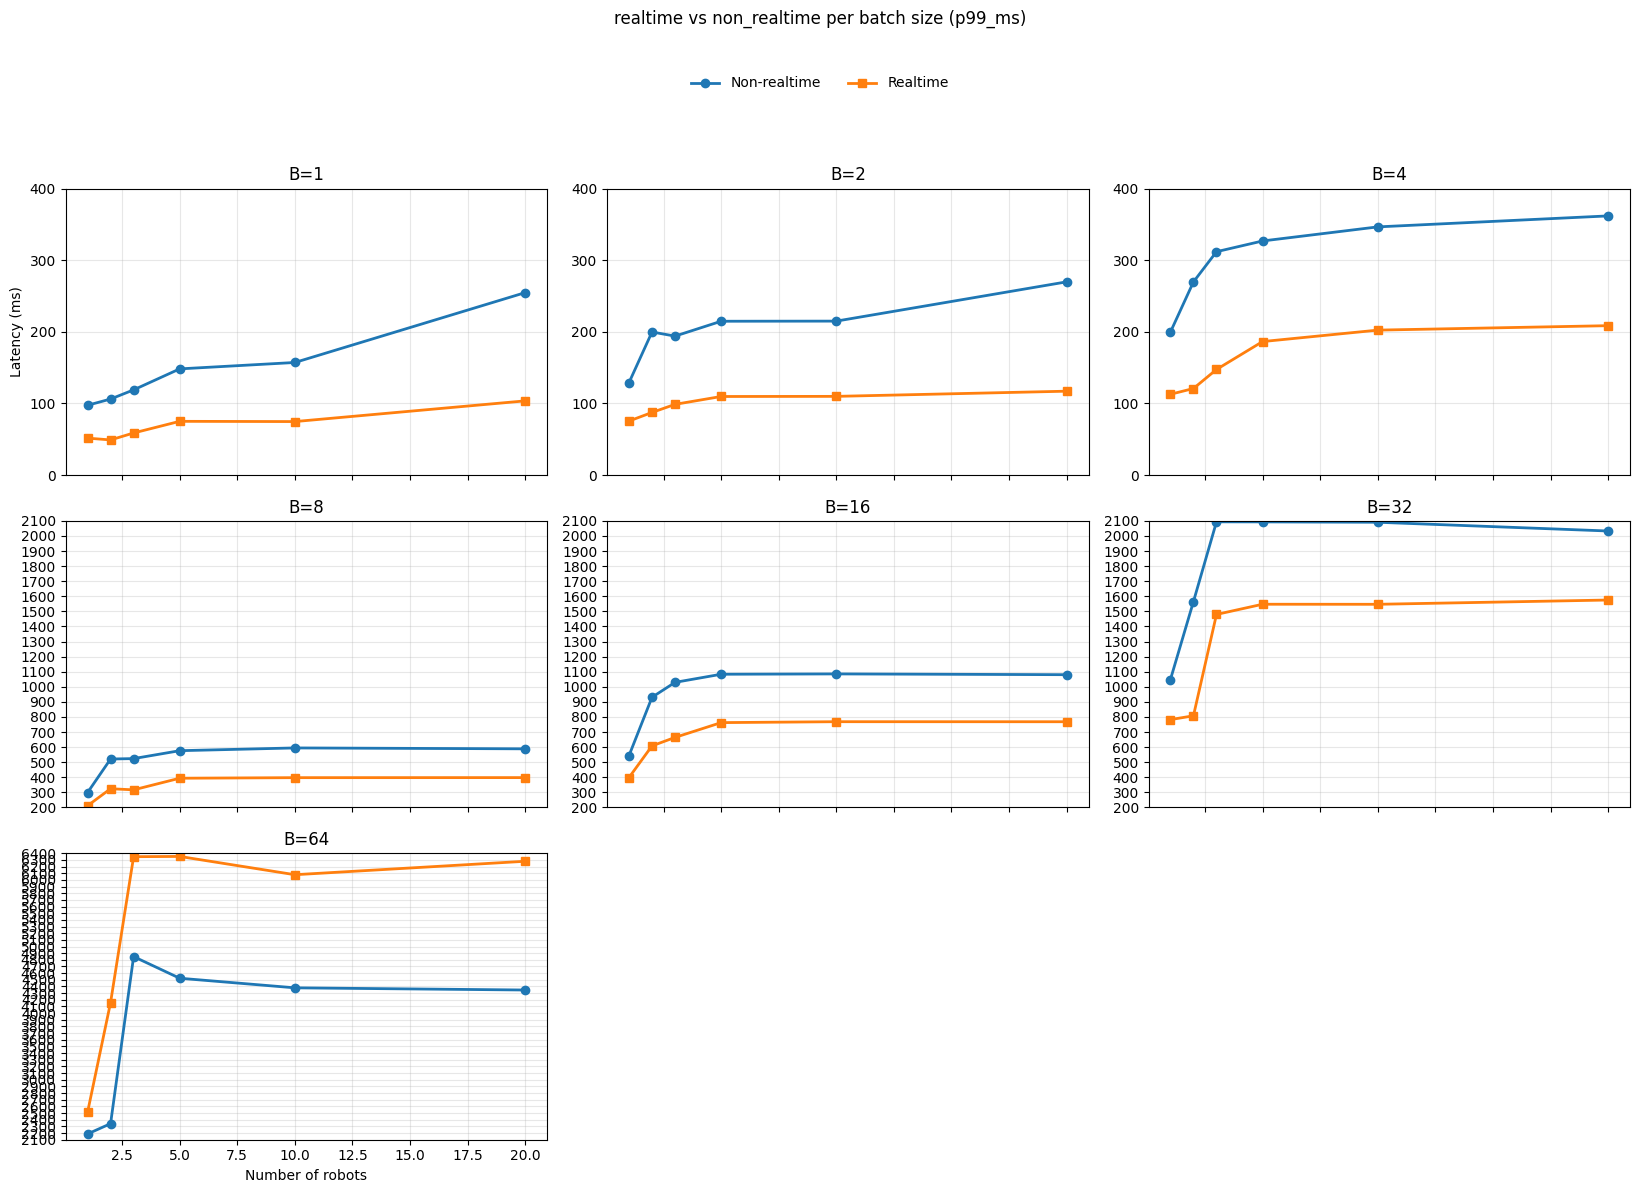

In [53]:
# Optional view: per-batch-size subplots, each comparing realtime vs non_realtime
# (Only meaningful when batch sizes are enabled)

BATCH_SIZES_SELECTED = resolve_batch_sizes(latency_df, include=[1, 2, 4, 8, 16, 32, 64], exclude=[])

if not PLOT_BATCH_SIZES:
    print("PLOT_BATCH_SIZES=False, skipping per-batch-size subplot grid.")
else:
    metric = METRIC

    # Use the same selection as the main plots
    batch_sizes = BATCH_SIZES_SELECTED
    num_robots_order = sorted(latency_df["num_robots"].dropna().unique().astype(int).tolist())

    n = len(batch_sizes)
    cols = 3
    rows = int(np.ceil(n / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(5.5 * cols, 4.0 * rows), sharex=True, sharey=False)
    axes = np.atleast_1d(axes).flatten()

    styles = {
        "non_realtime": {"color": "C0", "marker": "o", "label": "Non-realtime"},
        "realtime": {"color": "C1", "marker": "s", "label": "Realtime"},
    }

    # Track per-row y-limits so each row is fit to its content (snapped to 100ms ticks)
    row_mins = [np.inf] * rows
    row_maxs = [-np.inf] * rows
    row_has_data = [False] * rows

    for i, b in enumerate(batch_sizes):
        ax = axes[i]
        r = i // cols

        for mode, style in styles.items():
            sub = latency_df[(latency_df["batch_size"] == b) & (latency_df["mode"] == mode)].copy()
            if sub.empty:
                continue
            sub = sub.set_index("num_robots").reindex(num_robots_order).reset_index()

            ys = pd.to_numeric(sub[metric], errors="coerce").to_numpy(dtype=float)
            ys = ys[np.isfinite(ys)]
            if ys.size:
                row_mins[r] = float(min(row_mins[r], ys.min()))
                row_maxs[r] = float(max(row_maxs[r], ys.max()))
                row_has_data[r] = True

            ax.plot(
                sub["num_robots"],
                sub[metric],
                color=style["color"],
                marker=style["marker"],
                linewidth=2,
                label=style["label"],
            )

        ax.set_title(f"B={b}")
        ax.grid(True, alpha=0.3)
        ax.yaxis.set_major_locator(MultipleLocator(100))

    # Hide unused axes
    for j in range(n, len(axes)):
        axes[j].axis("off")

    # Fit each row's y-range tightly to its data (snapped to 100ms tick boundaries)
    for r in range(rows):
        if not row_has_data[r]:
            continue

        lo = row_mins[r]
        hi = row_maxs[r]
        if not (np.isfinite(lo) and np.isfinite(hi)):
            continue

        lo_tick = 100.0 * np.floor(lo / 100.0)
        hi_tick = 100.0 * np.ceil(hi / 100.0)
        if hi_tick <= lo_tick:
            hi_tick = lo_tick + 100.0

        for idx in range(r * cols, min((r + 1) * cols, len(axes))):
            ax = axes[idx]
            if ax.has_data():
                ax.set_ylim(lo_tick, hi_tick)

    axes[0].set_ylabel("Latency (ms)")
    for ax in axes[-cols:]:
        if ax.has_data():
            ax.set_xlabel("Number of robots")

    # Title + legend (put legend under title)
    handles, labels = axes[0].get_legend_handles_labels()
    fig.suptitle(f"realtime vs non_realtime per batch size ({metric})", y=0.99)
    if handles:
        fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 0.945), ncol=2, frameon=False)

    fig.tight_layout(rect=[0, 0, 1, 0.90])
    plt.show()


In [39]:
# Success rate aggregation
succ_rows = []

for batch_size, num_robots, mode, exp_dir in iter_experiment_dirs(SWEEP_ROOT):
    success_rate, n_episodes = load_success_rate(exp_dir)
    succ_rows.append(
        {
            "batch_size": int(batch_size),
            "num_robots": int(num_robots),
            "mode": str(mode),
            "success_rate": float(success_rate),
            "n_episodes": int(n_episodes),
        }
    )

success_df = (
    pd.DataFrame(succ_rows)
    .sort_values(["batch_size", "num_robots", "mode"])
    .reset_index(drop=True)
)
success_df


,batch_size,num_robots,mode,success_rate,n_episodes
0,1,1,non_realtime,0.400000,10
1,1,1,realtime,0.400000,10
2,1,2,non_realtime,0.500000,20
3,1,2,realtime,0.500000,20
4,1,3,non_realtime,0.433333,30
...,...,...,...,...,...
79,64,5,realtime,0.000000,50
80,64,10,non_realtime,0.000000,100
81,64,10,realtime,0.000000,100
82,64,20,non_realtime,0.000000,200


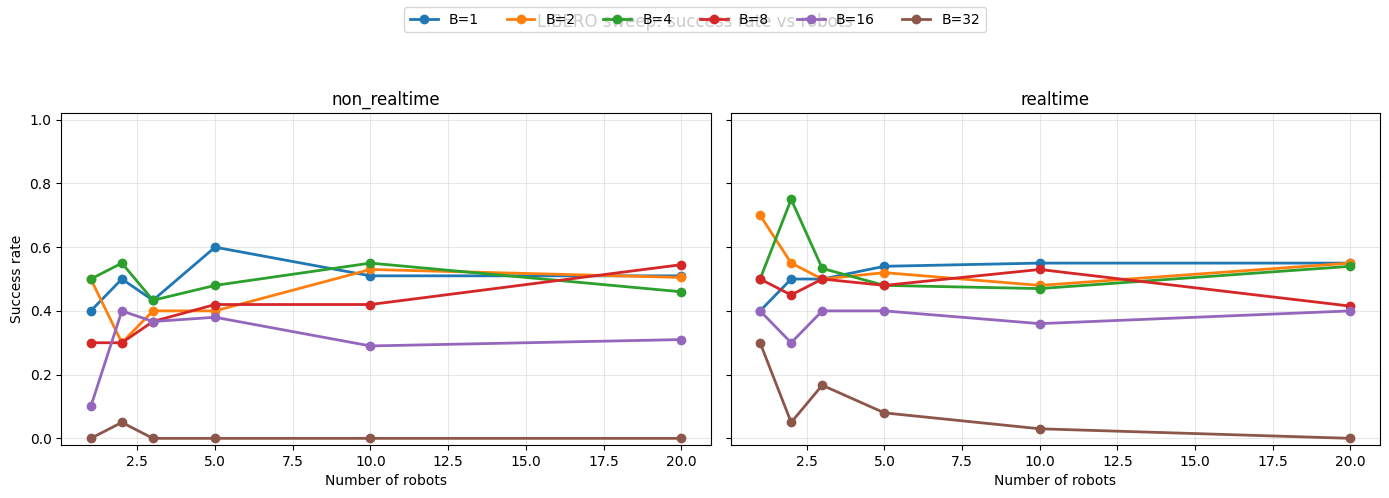

In [40]:
def plot_success_rate_vs_robots_sweep(
    df: pd.DataFrame,
    *,
    batch_sizes: Optional[List[int]] = None,
    num_robots_order: Optional[List[int]] = None,
):
    """Two-panel plot: (non_realtime) vs (realtime), lines for each batch size."""

    if batch_sizes is None:
        batch_sizes = resolve_batch_sizes(df, include=BATCH_SIZES_INCLUDE, exclude=BATCH_SIZES_EXCLUDE)

    if num_robots_order is None:
        num_robots_order = sorted(df["num_robots"].dropna().unique().astype(int).tolist())

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    mode_to_ax = {"non_realtime": axes[0], "realtime": axes[1]}

    colors = {b: f"C{i % 10}" for i, b in enumerate(batch_sizes)}

    for mode, ax in mode_to_ax.items():
        for b in batch_sizes:
            sub = df[(df["mode"] == mode) & (df["batch_size"] == b)].copy()
            if sub.empty:
                continue
            sub = sub.set_index("num_robots").reindex(num_robots_order).reset_index()
            ax.plot(
                sub["num_robots"],
                sub["success_rate"],
                marker="o",
                linewidth=2,
                color=colors[b],
                label=f"B={b}",
            )

        ax.set_title(mode)
        ax.set_xlabel("Number of robots")
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-0.02, 1.02)

    axes[0].set_ylabel("Success rate")
    fig.suptitle("LIBERO sweep: success rate vs robots")

    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc="upper center", ncol=min(len(labels), 7))

    fig.tight_layout(rect=[0, 0, 1, 0.92])
    return fig, axes


def plot_success_rate_vs_robots_fixed_batch(
    df: pd.DataFrame,
    *,
    batch_size: int,
    num_robots_order: Optional[List[int]] = None,
):
    sub_df = df[df["batch_size"] == batch_size].copy()
    if sub_df.empty:
        raise ValueError(f"No rows found for batch_size={batch_size}")

    if num_robots_order is None:
        num_robots_order = sorted(sub_df["num_robots"].dropna().unique().astype(int).tolist())

    fig, ax = plt.subplots(figsize=(8, 5))

    styles = {
        "non_realtime": {"color": "C0", "marker": "o", "label": "Non-realtime"},
        "realtime": {"color": "C1", "marker": "s", "label": "Realtime"},
    }

    for mode, style in styles.items():
        mdf = sub_df[sub_df["mode"] == mode].copy()
        if mdf.empty:
            continue
        mdf = mdf.set_index("num_robots").reindex(num_robots_order).reset_index()
        ax.plot(
            mdf["num_robots"],
            mdf["success_rate"],
            color=style["color"],
            marker=style["marker"],
            linewidth=2,
            label=style["label"],
        )

    ax.set_xlabel("Number of robots")
    ax.set_ylabel("Success rate")
    ax.set_title(f"LIBERO: success rate vs robots (B={batch_size})")
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.02, 1.02)
    ax.legend()

    fig.tight_layout()
    return fig, ax


# Plot success rate using the same batch-size selection config as latency
if PLOT_BATCH_SIZES:
    fig, axes = plot_success_rate_vs_robots_sweep(success_df, batch_sizes=BATCH_SIZES_SELECTED)
else:
    fig, ax = plot_success_rate_vs_robots_fixed_batch(success_df, batch_size=FIXED_BATCH_SIZE)
plt.show()
